In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import evaluator
from hwnas import main
import ast
from search_space import VGG8ModelSpaceCIFAR10
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import torch
from hwnas import hardware_aware_performance_estimation
from evaluator import test_epoch, train_epoch
import util
from collections import OrderedDict


In [96]:
df = pd.read_csv("../output_short_training/results_evo.csv", header=None)
df.columns = ["context", "accuracy", "latency", "energy", "area"]

df["metric"] = df.iloc[:,1:5].apply(lambda row: evaluator.objective(*row, w_acc=100, w_lat=1, w_en=1), axis=1)
df

,context,accuracy,latency,energy,area,metric
0,"{'out_size_conv1': 16, 'kernel_size_conv1': 5,...",0.408381,1.087106e+06,9.866557e+04,1.208983e+08,29.807631
1,"{'out_size_conv1': 16, 'kernel_size_conv1': 5,...",0.391335,1.266034e+06,7.426278e+04,1.122628e+08,28.160306
2,"{'out_size_conv1': 64, 'kernel_size_conv1': 3,...",0.417614,2.837147e+06,1.058518e+06,2.331611e+08,29.283783
3,"{'out_size_conv1': 64, 'kernel_size_conv1': 7,...",0.389915,5.566402e+06,5.536506e+06,1.459416e+09,25.502667
4,"{'out_size_conv1': 32, 'kernel_size_conv1': 7,...",0.578125,2.653740e+06,5.934562e+05,3.281527e+08,45.615253
...,...,...,...,...,...,...
296,"{'out_size_conv1': 32, 'kernel_size_conv1': 5,...",0.569602,2.856357e+06,9.159512e+05,4.404154e+08,44.542542
297,"{'out_size_conv1': 32, 'kernel_size_conv1': 7,...",0.479403,2.763921e+06,7.483437e+05,3.972374e+08,35.624714
298,"{'out_size_conv1': 32, 'kernel_size_conv1': 5,...",0.603693,2.703188e+06,6.082944e+05,3.367883e+08,48.153328
299,"{'out_size_conv1': 32, 'kernel_size_conv1': 5,...",0.459517,2.799260e+06,9.012489e+05,4.231442e+08,33.549817


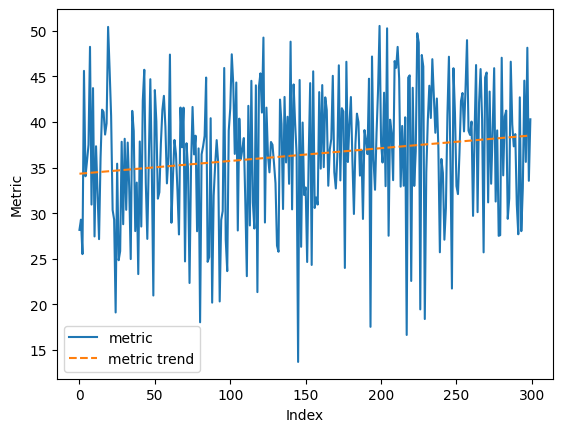

In [94]:
fig, ax = plt.subplots()

# Plot the raw data
ax.plot(df.index, df.metric, label='metric')
# ax.plot(df.index, df.energy, label='energy')

# Add trend line
df_with_index = df.reset_index()
model = sm.formula.ols(formula='metric ~ index', data=df_with_index)
res = model.fit()
ax.plot(df.index, res.fittedvalues, '--', label='metric trend')

ax.legend()
ax.set_xlabel('Index')
ax.set_ylabel('Metric')
plt.show()

In [97]:
k = 10
top_k = df.sort_values('metric', ascending=False).head(k)
context_list = top_k['context'].tolist()
state_dicts = [{k: v for k, v in ast.literal_eval(d).items() if k != '__arch__'} for d in context_list]
state_dicts

[{'out_size_conv1': 32,
  'kernel_size_conv1': 5,
  'conv2_choice': 1,
  'channel_multiplier': 2,
  'kernel_size_conv2': 3,
  'conv3_choice': 0,
  'kernel_size_conv3': 5,
  'conv4_choice': 0,
  'kernel_size_conv4': 3,
  'conv6_choice': 1,
  'pool_choice': 1},
 {'out_size_conv1': 16,
  'kernel_size_conv1': 7,
  'conv2_choice': 1,
  'channel_multiplier': 2,
  'kernel_size_conv2': 3,
  'conv3_choice': 0,
  'kernel_size_conv3': 5,
  'conv4_choice': 1,
  'kernel_size_conv4': 5,
  'conv6_choice': 0,
  'pool_choice': 0},
 {'out_size_conv1': 64,
  'kernel_size_conv1': 3,
  'conv2_choice': 1,
  'channel_multiplier': 1.5,
  'kernel_size_conv2': 3,
  'conv3_choice': 1,
  'kernel_size_conv3': 3,
  'conv4_choice': 1,
  'kernel_size_conv4': 5,
  'conv6_choice': 0,
  'pool_choice': 0},
 {'out_size_conv1': 32,
  'kernel_size_conv1': 7,
  'conv2_choice': 1,
  'channel_multiplier': 1.5,
  'kernel_size_conv2': 3,
  'conv3_choice': 0,
  'kernel_size_conv3': 3,
  'conv4_choice': 0,
  'kernel_size_conv4': 5

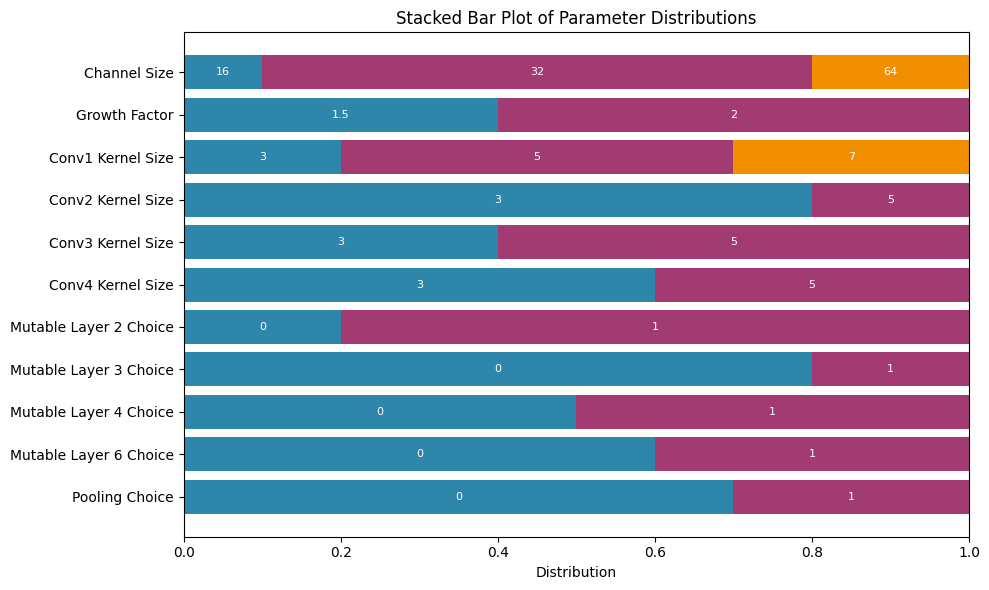

In [98]:
param_options, param_distr = main.combine_model_dict(state_dicts)

fig, ax = plt.subplots(figsize=(10, 6))


label_rename_map = {
    'pool_choice': 'Pooling Choice',
    'conv6_choice': 'Mutable Layer 6 Choice',
    'conv4_choice': 'Mutable Layer 4 Choice',
    'conv3_choice': 'Mutable Layer 3 Choice',
    'conv2_choice': 'Mutable Layer 2 Choice',
    'kernel_size_conv4': 'Conv4 Kernel Size',
    'kernel_size_conv3': 'Conv3 Kernel Size',
    'kernel_size_conv2': 'Conv2 Kernel Size',
    'kernel_size_conv1': 'Conv1 Kernel Size',
    'channel_multiplier': 'Growth Factor',
    'out_size_conv1': 'Channel Size'
}
order = list(label_rename_map.keys())

y_labels = list(param_options.keys())
y_pos = np.arange(len(y_labels))

params_ord = OrderedDict()

for key in order:
    params_ord.update({label_rename_map.get(key) : param_options.get(key)})
max_choices = max(len(v) for v in params_ord.values())
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592A37']
bottom = np.zeros(len(y_labels))


for choice_idx in range(max_choices):
    heights = []
    labels = []
    for key in order:
        param_values = params_ord[label_rename_map[key]]
        param_distribution = param_distr[key]
        if choice_idx < len(param_values):
            heights.append(param_distribution[choice_idx])
            labels.append(f"{param_values[choice_idx]}")
        else:
            heights.append(0)
            labels.append("")
    bars = ax.barh(y_pos, heights, left=bottom, label=f'Value: {labels[0] if labels.count(labels[0]) == len(labels) else f"Option {i}"}', color=colors[choice_idx % len(colors)],)

    for i, (bar, height, label) in enumerate(zip(bars, heights, labels)):
        # if height > 0.05:  # Only show labels for reasonably sized segments
            ax.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_y() + bar.get_height()/2, 
                    label, 
                    ha='center', va='center', 
                    fontsize=8,
                    color='white')

    bottom += heights


ax.set_yticks(y_pos)
ax.set_yticklabels(list(params_ord.keys()))
ax.set_xlabel('Distribution')
ax.set_title('Stacked Bar Plot of Parameter Distributions')
# ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [99]:
model_space = VGG8ModelSpaceCIFAR10()

In [ ]:
def evaluate_top_model(
    model,
    max_epochs=100,
    batch_size=128,
    num_workers=0,  # for Windows
    patience=15,
    min_delta=1,
    device="cuda",
    lr=0.01
):
    print("Architecture \n", model)
    counter=0
    best_metric=-np.inf
    util.replace_conv_bias_with_bn(module=model, device=device)
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
    ])

    full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    train_dataset, val_dataset = random_split(full_train, [45000, 5000])
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(max_epochs):
        print("Epoch", epoch)
        train_epoch(model, device, train_loader, optimizer)
        accuracy = test_epoch(model, device, val_loader)
        val_metric = accuracy
        if counter >= patience:
            print("Early stopping triggered")
            break
        if val_metric > best_metric + min_delta:
            best_metric = val_metric
            counter = 0
            print("Reset Patience")
        else:
            counter += 1
            
    test_accuracy = test_epoch(model, device, test_loader)
    print(f"Final Test Accuracy Original: {test_accuracy:.2f}")
    print("Training done.")
    acc, lat, eng, area = hardware_aware_performance_estimation.get_hardware_metrics(model, train_loader=train_loader, test_loader=test_loader, val_loader=val_loader, num_classes=10, sim_config="../MNSIM-2.0/SimConfig.ini")
    final_metric = evaluator.objective(acc, lat, eng, area)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Latency: {lat:.4f}")
    print(f"Energy: {eng:.4f}")
    print(f"Area: {area:.4f}")
    print(f"Final Metric: {final_metric:.4f}")
    return final_metric, acc, lat, eng, area, accuracy

In [103]:
model = model_space.freeze(state_dicts[0])
final_metric, acc, lat, eng, area, orig_accuracy = evaluate_top_model(model)
    
result_0 = {
    "index": i,
    "final_metric": final_metric,
    "accuracy": acc,
    "latency": lat,
    "energy": eng,
    "area": area,
    "orig_accuracy" : orig_accuracy
}

Architecture 
 VGG8ModelSpaceCIFAR10(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): DepthwiseSeparableConv(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Identity()
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=512, out_features=10, bias=False)
)
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


Training: 100%|██████████| 352/352 [00:16<00:00, 21.04it/s]



Test set: Accuracy: 2612/5000 (52%)

Reset Patience

Test set: Accuracy: 5427/10000 (54%)

Final Test Accuracy Digital: 54.27
Training done.
no match for _tensor_constant0 _tensor_constant0
Note: MSIM 2.0 only uses parameter 'features' for BatchNorm2D. Default for everything else.
Note: MSIM 2.0 only uses parameter 'features' for BatchNorm2D. Default for everything else.
Note: MSIM 2.0 only uses parameter 'features' for BatchNorm2D. Default for everything else.
Note: MSIM 2.0 only uses parameter 'features' for BatchNorm2D. Default for everything else.
Note: MSIM 2.0 only uses parameter 'features' for BatchNorm2D. Default for everything else.
Note: MSIM 2.0 only uses parameter 'features' for BatchNorm2D. Default for everything else.
Note: MSIM 2.0 only uses parameter 'features' for BatchNorm2D. Default for everything else.
C:\Users\Luis\Documents\Uni-DESKTOP-F7N3QC8\TU Dresden\4. Semester\CC-Seminar\MNSIM-2.0\SimConfig.ini
run on device cuda
load state_dict


c:\Users\Luis\miniconda3\envs\hwnascim\lib\site-packages\torch\fx\_symbolic_trace.py:602: UserWarning: Was not able to add assertion to guarantee correct input x to specialized function. It is up to the user to make sure that your inputs match the inputs you specialized the function with.
  warnings.warn(


Total crossbar number: 312
Latency: 2767784.550396113 ns
Area: 354059445.56061774 um^2
Power: 42.823195311577756 W
Energy: 619543.4307030276 nJ
Hardware modeling time: 0.2599513530731201 s
Original accuracy: 0.5404829545454546
Eval on device: cuda


Processing layers: 100%|██████████| 26/26 [00:01<00:00, 17.66it/s]

PIM-based computing accuracy: 0.4630681818181818
Accuracy modeling time: 19.252152919769287
Accuracy: 0.4631
Latency: 2767784.5504
Energy: 619543.4307
Area: 354059445.5606
Final Metric: -11.7711


In [ ]:
model = model_space.freeze(state_dicts[1])
final_metric, acc, lat, eng, area, orig_accuracy = evaluate_top_model(model)
    
result_1 = {
    "index": i,
    "final_metric": final_metric,
    "accuracy": acc,
    "latency": lat,
    "energy": eng,
    "area": area,
    "orig_accuracy" : orig_accuracy
}

In [ ]:
model = model_space.freeze(state_dicts[2])
final_metric, acc, lat, eng, area, orig_accuracy = evaluate_top_model(model)
    
result_2 = {
    "index": i,
    "final_metric": final_metric,
    "accuracy": acc,
    "latency": lat,
    "energy": eng,
    "area": area,
    "orig_accuracy" : orig_accuracy
}

In [ ]:
results = []
for i in range(0, 301, 50):
    model = model_space.freeze(state_dicts[i])
    final_metric, acc, lat, eng, area, orig_accuracy = evaluate_top_model(model)
    results.append({
        'index': i,
        'final_metric': final_metric,
        'accuracy': acc,
        'latency': lat,
        'energy': eng,
        'area': area,
        "orig_accuracy" : orig_accuracy
    })
df_eval = pd.DataFrame(results)
df

Architecture 
 VGG8ModelSpaceCIFAR10(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): DepthwiseSeparableConv(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Identity()
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=512, out_features=10, bias=False)
)
Files already downloaded and verified
Files already downloaded and verified
Epoch 0


Training:   7%|▋         | 26/352 [00:01<00:19, 16.94it/s]


KeyboardInterrupt: 